In [106]:
import pandas as pd
from glob import glob
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

In [11]:
train_label_path = './stage1_train_labels.csv'
nuclei_frame = pd.read_csv(train_label_path)
print(len(nuclei_frame))
nuclei_frame.head(3)

29461


,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...


In [35]:
nuclei_groups = nuclei_frame.groupby(nuclei_frame.ImageId)
len(nuclei_groups)

670

In [105]:
ImageId = nuclei_groups.groups.keys()
ImageId = list(ImageId)
#提取出来ImageID后就可以保存了
df = pd.DataFrame()
df['ImageId'] = ImageId
df.to_csv('trainIDs.csv')

# pd.DataFrame(ImageId,columns=['ImageId']).to_csv('trainIDs.csv')
IDs = pd.read_csv('trainIDs.csv')
list(IDs['ImageId'])
# IDs = list(IDs)
# print(ImageId[0])
# IDs

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d3188cc751cdfd566b

In [124]:
label_path = './stage1_sample_submission.csv'
nuclei_frame = pd.read_csv(label_path)
nuclei_groups = nuclei_frame.groupby(nuclei_frame.ImageId)
ImageId = list(nuclei_groups.groups.keys())
df = pd.DataFrame()
df['ImageId'] = ImageId
df.to_csv('test_ids.csv')

In [47]:
masks = nuclei_groups.get_group(ImageId[0])
masks = list(masks.EncodedPixels)

In [72]:
def show_image(id,train=True):
    if train: DIR = './stage1_train/'
    else: DIR = './stage1_test/'
    im_path = glob(DIR + id + '/images/*')[0]
    im = Image.open(im_path)
    plt.imshow(im)


In [73]:
def show_mask(id,train=True):
    if train: DIR = './stage1_train/'
    else: DIR = './stage1_test/'
    im_path = glob(DIR + id + '/whole_mask.PNG')[0]
    im = Image.open(im_path)
    plt.imshow(im)


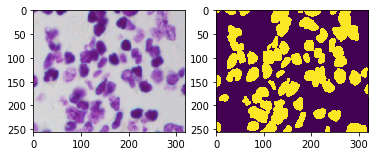

In [80]:
n = 2
plt.subplot(121)
show_image(ImageId[n])
plt.subplot(122)
show_mask(ImageId[n])
plt.show()

In [133]:
TRAIN_IDS = './train_ids.csv'
TEST_IDS = './test_ids.csv'
TRAIN_DIR = './stage1_train/'
TEST_DIR = './stage1_test/'


class NucleiDataset(Dataset):
    def __init__(self, subset = 'train', transform = None):
        super(NucleiDataset,self).__init__()
        self.transform = transform
        self.subset = subset
        self.ImageId = self.load_image_id(subset)
    
    def _len_(self):
        return len(self.ImageId)
    
    def __get__item(self, index):
        img_id = self.ImageId[index]
        img,target = self.open_image(img_id)
        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
        return img, target
    
    def load_image_id(self,subset):
        if subset == 'train':
            df = pd.read_csv(TRAIN_IDS)
        else:
            df = pd.read_csv(TEST_IDS)
        return list(df)

    def open_image(self,img_id):
        if self.subset == 'train':
            img_path = glob(TRAIN_DIR + img_id + '/images/*')[0]
            mask_path = os.path.join(TRAIN_DIR + img_id + '/whole_mask.PNG')
            return Image.open(img_path),Image.open(mask_path)
        else:
            img_path = glob(TEST_DIR + img_id + '/images/*')[0]
            return Image.open(img_path),None